#### METHODS

In [1]:
# Import libraries
import numpy as np 
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json 
!pip install geopy
from geopy.geocoders import Nominatim 
import requests 
from pandas.io.json import json_normalize 
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

#### Source Data was found at https://simplemaps.com/data/world-cities

In [2]:
df = pd.read_csv(r'C:/Users/marsh/Documents/Data Science/capstone/uscities.csv')
df.head()

,city,state_id,state_name,county_fips,county_name,lat,lng,population,density,timezone
0,South Creek,WA,Washington,53053,Pierce,46.9994,-122.3921,2500,125.0,America/Los_Angeles
1,Roslyn,WA,Washington,53037,Kittitas,47.2507,-121.0989,947,84.0,America/Los_Angeles
2,Sprague,WA,Washington,53043,Lincoln,47.3048,-117.9713,441,163.0,America/Los_Angeles
3,Gig Harbor,WA,Washington,53053,Pierce,47.3352,-122.5968,9507,622.0,America/Los_Angeles
4,Lake Cassidy,WA,Washington,53061,Snohomish,48.0639,-122.0920,3591,131.0,America/Los_Angeles


In [3]:
df.shape

(28889, 10)

#### Cleaning and segmenting the DATA: Column names, and data other than Wisconsin.

In [4]:
df.rename(columns={'lat':'Latitude', 'lng':'Longitude','state_id': 'State', 'county_name':'County', 'county_fips':'Zip', 'city':'City', 'density':'Density'}, inplace=True)
df.head()

,City,State,state_name,Zip,County,Latitude,Longitude,population,Density,timezone
0,South Creek,WA,Washington,53053,Pierce,46.9994,-122.3921,2500,125.0,America/Los_Angeles
1,Roslyn,WA,Washington,53037,Kittitas,47.2507,-121.0989,947,84.0,America/Los_Angeles
2,Sprague,WA,Washington,53043,Lincoln,47.3048,-117.9713,441,163.0,America/Los_Angeles
3,Gig Harbor,WA,Washington,53053,Pierce,47.3352,-122.5968,9507,622.0,America/Los_Angeles
4,Lake Cassidy,WA,Washington,53061,Snohomish,48.0639,-122.0920,3591,131.0,America/Los_Angeles


#### Drop unneeded columns

In [5]:
df.drop(columns={'state_name', 'population', 'timezone'}, inplace=True)
df.head()

,City,State,Zip,County,Latitude,Longitude,Density
0,South Creek,WA,53053,Pierce,46.9994,-122.3921,125.0
1,Roslyn,WA,53037,Kittitas,47.2507,-121.0989,84.0
2,Sprague,WA,53043,Lincoln,47.3048,-117.9713,163.0
3,Gig Harbor,WA,53053,Pierce,47.3352,-122.5968,622.0
4,Lake Cassidy,WA,53061,Snohomish,48.0639,-122.0920,131.0


#### Segment WI data

In [6]:
WI_data = df[df.State == 'WI']
WI_data.head()

,City,State,Zip,County,Latitude,Longitude,Density
698,Stone Lake,WI,55129,Washburn,45.8445,-91.5502,74.0
699,Nelson,WI,55011,Buffalo,44.4214,-92.0044,101.0
700,Fennimore,WI,55043,Grant,42.9793,-90.6491,556.0
701,Chenequa,WI,55133,Waukesha,43.1229,-88.3838,66.0
702,Helenville,WI,55055,Jefferson,43.0165,-88.6999,130.0


#### Check Coordinates from the data. (Address is The Comet Cafe)

In [7]:
address = '1947 N Farwell Ave, Milwaukee, WI 53202'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The coordinates of Ccomet are {}, {}.'.format(latitude, longitude))

C:\Users\marsh\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The coordinates of Ccomet are 43.056098, -87.8895056.


#### Install Folium for visualization

In [8]:
!pip install folium
import folium # map rendering library
print('Libraries imported.')

Libraries imported.


In [9]:
map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, city, county in zip(WI_data['Latitude'], WI_data['Longitude'], WI_data['City'], WI_data['County']):
    label = '{}, {}'.format(county, city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='dark blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        ).add_to(map) 
map

#### Milwaukee County and Waukesha County are the two major population centers in Southeast Wisconsins. So for a place to live we will be looking at these two counties. First Lets work on for Milwaukee County.

In [10]:
Mil_data = WI_data[WI_data.County == 'Milwaukee']
Mil_data.shape
Mil_data

,City,State,Zip,County,Latitude,Longitude,Density
731,Greendale,WI,55079,Milwaukee,42.9370,-88.0018,982.0
766,Oak Creek,WI,55079,Milwaukee,42.8803,-87.9009,493.0
825,Wauwatosa,WI,55079,Milwaukee,43.0615,-88.0347,1409.0
863,Whitefish Bay,WI,55079,Milwaukee,43.1132,-87.9003,2545.0
903,River Hills,WI,55079,Milwaukee,43.1717,-87.9353,119.0
920,Franklin,WI,55079,Milwaukee,42.8854,-88.0104,403.0
940,Fox Point,WI,55079,Milwaukee,43.1581,-87.9013,900.0
958,South Milwaukee,WI,55079,Milwaukee,42.9120,-87.8627,1678.0
1011,West Allis,WI,55079,Milwaukee,43.0068,-88.0296,2033.0
1031,Brown Deer,WI,55079,Milwaukee,43.1743,-87.9750,1050.0


In [11]:
address = 'Milwaukee, WI'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The coords of Milwaukee are {}, {}.'.format(latitude, longitude))

C:\Users\marsh\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The coords of Milwaukee are 43.0349931, -87.922497.


#### Mapping Milwaukee County

In [12]:
map_mil = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(Mil_data['Latitude'], Mil_data['Longitude'], Mil_data['City']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=15,
        popup=label,
        color='dark blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_mil)  
    
map_mil

#### Setting up Foursquare

In [13]:
CLIENT_ID = '1PQYYST2E0P5CGBCCFYBBSQ0EXTOEAQ4CPU24WDIAT2S41H2' # your Foursquare ID
CLIENT_SECRET = 'QDT5PSYKEN0RJNL415D2DOBG1FHLUG5U0QGPJ51ODMKM3RQF' # your Foursquare Secret
VERSION = '20180605'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 1PQYYST2E0P5CGBCCFYBBSQ0EXTOEAQ4CPU24WDIAT2S41H2
CLIENT_SECRET:QDT5PSYKEN0RJNL415D2DOBG1FHLUG5U0QGPJ51ODMKM3RQF


#### We will look at the City of Milwaukee first.

In [14]:
Mil_data.loc[1150,'City']


'Milwaukee'

In [15]:
city_latitude = Mil_data.loc[1150, 'Latitude'] 
city_longitude = Mil_data.loc[1150, 'Longitude'] 
city_name = Mil_data.loc[1150, 'City']

print('Latitude and longitude values of {} are {}, {}.'.format(city_name, 
                                                               city_latitude, 
                                                               city_longitude))

Latitude and longitude values of Milwaukee are 43.0642, -87.9673.


In [27]:
LIMIT = 100
radius = 750
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    city_latitude, 
    city_longitude, 
    radius, 
    LIMIT)
url 

'https://api.foursquare.com/v2/venues/explore?&client_id=1PQYYST2E0P5CGBCCFYBBSQ0EXTOEAQ4CPU24WDIAT2S41H2&client_secret=QDT5PSYKEN0RJNL415D2DOBG1FHLUG5U0QGPJ51ODMKM3RQF&v=20180605&ll=43.0642,-87.9673&radius=750&limit=100'

#### Get results

In [28]:
results = requests.get(url).json()

In [29]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [30]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

C:\Users\marsh\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Judy's Red Hot,Hot Dog Joint,43.061598,-87.974138
1,Ralph's Coffee,Bar,43.059809,-87.971098
2,Domino's Pizza,Pizza Place,43.060395,-87.966470
3,Wendy’s,Fast Food Restaurant,43.060389,-87.971561
4,Buy Rite Liquor,Liquor Store,43.060653,-87.967503
5,Pick 'n Save,Grocery Store,43.061949,-87.959099
6,Cosmo Beauty,Cosmetics Shop,43.060461,-87.971952
7,Viet Hoa Supermarket,Grocery Store,43.060761,-87.974826
8,Family First Fish Market,American Restaurant,43.067846,-87.961733
9,Bus Stop Coffee Shop,Coffee Shop,43.058878,-87.969553


##### Now lets look at the County

In [31]:
def getNearbyVenues(names, latitudes, longitudes, radius=750):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [32]:
mil_venues = getNearbyVenues(names=Mil_data['City'],
                                   latitudes=Mil_data['Latitude'],
                                   longitudes=Mil_data['Longitude']
                                  )

Greendale
Oak Creek
Wauwatosa
Whitefish Bay
River Hills
Franklin
Fox Point
South Milwaukee
West Allis
Brown Deer
West Milwaukee
Milwaukee
St. Francis
Hales Corners
Shorewood
Greenfield
Cudahy
Glendale
Bayside


In [33]:
mil_venues


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Greendale,42.9370,-88.0018,Vintage 38,42.941458,-87.995703,Wine Bar
1,Greendale,42.9370,-88.0018,Joey Gerard's,42.942106,-87.996551,Restaurant
2,Greendale,42.9370,-88.0018,Roots Salon,42.939973,-87.996585,Salon / Barbershop
3,Greendale,42.9370,-88.0018,Panther Pub & Eatery,42.940589,-87.996353,Sports Bar
4,Greendale,42.9370,-88.0018,Ricardo's Pizza,42.941768,-87.996351,Pizza Place
5,Greendale,42.9370,-88.0018,Ferch's Malt Shoppe & Grille,42.941553,-87.995826,Ice Cream Shop
6,Greendale,42.9370,-88.0018,National Bakery & Deli,42.941525,-87.996345,Bakery
7,Greendale,42.9370,-88.0018,Downtown Greendale Fountain,42.942182,-87.996121,Plaza
8,Greendale,42.9370,-88.0018,They Grow Like Weeds,42.941536,-87.995513,Thrift / Vintage Store
9,Greendale,42.9370,-88.0018,Broad Street Coffee Company,42.941603,-87.996285,Coffee Shop


In [35]:
mil_venues.shape

(351, 7)

Text(0, 0.5, 'Venue Count')

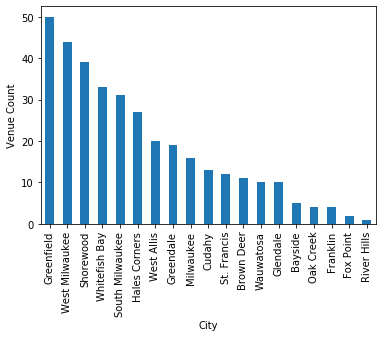

In [34]:
plot1=mil_venues["City"].value_counts().plot(kind = "bar")
plot1.set_xlabel('City')
plot1.set_ylabel('Venue Count')

In [36]:
venue_counts = mil_venues.groupby('City').count()
venue_counts

,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,
Bayside,5,5,5,5,5,5
Brown Deer,11,11,11,11,11,11
Cudahy,13,13,13,13,13,13
Fox Point,2,2,2,2,2,2
Franklin,4,4,4,4,4,4
Glendale,10,10,10,10,10,10
Greendale,19,19,19,19,19,19
Greenfield,50,50,50,50,50,50
Hales Corners,27,27,27,27,27,27


In [37]:
print('There are {} uniques categories.'.format(len(mil_venues['Venue Category'].unique())))


There are 123 uniques categories.


In [38]:
mil_onehot = pd.get_dummies(mil_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
mil_onehot['City'] = mil_venues['City'] 

# move neighborhood column to the first column
fixed_columns = [mil_onehot.columns[-1]] + list(mil_onehot.columns[:-1])
mil_onehot = mil_onehot[fixed_columns]

mil_onehot.head()

,City,Accessories Store,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Big Box Store,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Café,Cajun / Creole Restaurant,Candy Store,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Deli / Bodega,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Electronics Store,Farmers Market,Fast Food Restaurant,Flower Shop,Food Truck,Frame Store,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gas Station,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hardware Store,Hobby Shop,Home Service,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Theater,Insurance Office,Italian Restaurant,Jewelry Store,Kids Store,Liquor Store,Lounge,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mexican Restaurant,Mobile Phone Shop,New American Restaurant,Noodle House,Optical Shop,Organic Grocery,Outdoors & Recreation,Park,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pub,Rental Car Location,Reservoir,Restaurant,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Smoke Shop,Soccer Field,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Tailor Shop,Tennis Court,Tex-Mex Restaurant,Theater,Thrift / Vintage Store,Trail,Video Game Store,Video Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Greendale,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,Greendale,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Greendale,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Greendale,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Greendale,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [39]:
mil_onehot.shape

(351, 124)

In [40]:
mil_grouped = mil_onehot.groupby('City').mean().reset_index()
mil_grouped

,City,Accessories Store,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Big Box Store,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Café,Cajun / Creole Restaurant,Candy Store,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Deli / Bodega,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Electronics Store,Farmers Market,Fast Food Restaurant,Flower Shop,Food Truck,Frame Store,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gas Station,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hardware Store,Hobby Shop,Home Service,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Theater,Insurance Office,Italian Restaurant,Jewelry Store,Kids Store,Liquor Store,Lounge,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mexican Restaurant,Mobile Phone Shop,New American Restaurant,Noodle House,Optical Shop,Organic Grocery,Outdoors & Recreation,Park,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pub,Rental Car Location,Reservoir,Restaurant,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Smoke Shop,Soccer Field,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Tailor Shop,Tennis Court,Tex-Mex Restaurant,Theater,Thrift / Vintage Store,Trail,Video Game Store,Video Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Bayside,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.4,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.200000,0.000000,0.00,0.000000,0.000000,0.2,0.0000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.200000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
1,Brown Deer,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.00,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.090909,0.00,0.000000,0.000000,0.0,0.0000,0.181818,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.181818,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.181818,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.090909,0.000000,0.0,0.00,0.000000,0.000000,0.090909,0.0,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
2,Cudahy,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.230769,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0

In [41]:
num_top_venues = 5

for hood in mil_grouped['City']:
    print("----"+hood+"----")
    temp = mil_grouped[mil_grouped['City'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bayside----
               venue  freq
0      Garden Center   0.4
1       Home Service   0.2
2                Gym   0.2
3               Park   0.2
4  Mobile Phone Shop   0.0


----Brown Deer----
                 venue  freq
0                Hotel  0.18
1    Mobile Phone Shop  0.18
2         Liquor Store  0.18
3  American Restaurant  0.09
4                 Pool  0.09


----Cudahy----
          venue  freq
0           Bar  0.23
1    Sports Bar  0.15
2   Gas Station  0.08
3  Optical Shop  0.08
4   Flower Shop  0.08


----Fox Point----
             venue  freq
0             Pool   0.5
1  Organic Grocery   0.5
2              Pub   0.0
3            Plaza   0.0
4       Playground   0.0


----Franklin----
               venue  freq
0     Baseball Field  0.50
1          Reservoir  0.25
2               Park  0.25
3  Accessories Store  0.00
4  Mobile Phone Shop  0.00


----Glendale----
                  venue  freq
0                   Pub   0.2
1  Gym / Fitness Center   0.1
2                 

In [42]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [44]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
city_venues_sorted = pd.DataFrame(columns=columns)
city_venues_sorted['City'] = mil_grouped['City']

for ind in np.arange(mil_grouped.shape[0]):
    city_venues_sorted.iloc[ind, 1:] = return_most_common_venues(mil_grouped.iloc[ind, :], num_top_venues)

city_venues_sorted

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bayside,Garden Center,Home Service,Gym,Park,Flower Shop,Cosmetics Shop,Dance Studio,Deli / Bodega,Diner,Discount Store
1,Brown Deer,Mobile Phone Shop,Hotel,Liquor Store,Gym / Fitness Center,Sandwich Place,American Restaurant,Pool,Café,Electronics Store,Donut Shop
2,Cudahy,Bar,Sports Bar,Thrift / Vintage Store,Dive Bar,Furniture / Home Store,Optical Shop,Discount Store,Gas Station,Park,Flower Shop
3,Fox Point,Pool,Organic Grocery,Flower Shop,Convenience Store,Cosmetics Shop,Dance Studio,Deli / Bodega,Diner,Discount Store,Dive Bar
4,Franklin,Baseball Field,Reservoir,Park,Yoga Studio,Flower Shop,Cosmetics Shop,Dance Studio,Deli / Bodega,Diner,Discount Store
5,Glendale,Pub,Gas Station,Gym / Fitness Center,Dance Studio,Rental Car Location,Park,Baseball Field,Garden Center,Bar,Dog Run
6,Greendale,Park,Yoga Studio,Sports Bar,Arts & Crafts Store,Athletics & Sports,Bakery,Baseball Field,Coffee Shop,Ice Cream Shop,Pizza Place
7,Greenfield,Furniture / Home Store,Fast Food Restaurant,Italian Restaurant,Mobile Phone Shop,Cosmetics Shop,Salon / Barbershop,Shoe Store,Spa,Sushi Restaurant,Sandwich Place
8,Hales Corners,Sporting Goods Shop,Chinese Restaurant,Fast Food Restaurant,Shoe Store,Cosmetics Shop,Mexican Restaurant,Coffee Shop,Pet Store,Pharmacy,Pizza Place
9,Milwaukee,Cosmetics Shop,Bar,Convenience Store,Grocery Store,Pizza Place,Coffee Shop,Liquor Store,Cocktail Bar,Hot Dog Joint,American Restaurant


In [45]:
city_venues_sorted.shape

(19, 11)

#### Now to Cluster the Cities into 4

In [46]:
kclusters = 4

mil_grouped_clustering = mil_grouped.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(mil_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 3, 1, 0, 0, 0, 0, 0])

In [47]:
mil_merged = Mil_data

# add clustering labels
mil_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
mil_merged = mil_merged.join(city_venues_sorted.set_index('City'), on='City')

mil_merged

C:\Users\marsh\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,City,State,Zip,County,Latitude,Longitude,Density,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
731,Greendale,WI,55079,Milwaukee,42.9370,-88.0018,982.0,0,Park,Yoga Studio,Sports Bar,Arts & Crafts Store,Athletics & Sports,Bakery,Baseball Field,Coffee Shop,Ice Cream Shop,Pizza Place
766,Oak Creek,WI,55079,Milwaukee,42.8803,-87.9009,493.0,0,Trail,Playground,Lounge,Dive Bar,Fast Food Restaurant,Farmers Market,Electronics Store,Donut Shop,Dog Run,Discount Store
825,Wauwatosa,WI,55079,Milwaukee,43.0615,-88.0347,1409.0,0,Coffee Shop,Furniture / Home Store,Pool,Park,Outdoors & Recreation,Spa,Bank,Sporting Goods Shop,Pharmacy,Golf Course
863,Whitefish Bay,WI,55079,Milwaukee,43.1132,-87.9003,2545.0,3,Café,Gift Shop,Athletics & Sports,Park,Cosmetics Shop,New American Restaurant,Plaza,Pharmacy,Pet Store,Construction & Landscaping
903,River Hills,WI,55079,Milwaukee,43.1717,-87.9353,119.0,1,Sculpture Garden,Yoga Studio,Food Truck,Cosmetics Shop,Dance Studio,Deli / Bodega,Diner,Discount Store,Dive Bar,Dog Run
920,Franklin,WI,55079,Milwaukee,42.8854,-88.0104,403.0,0,Baseball Field,Reservoir,Park,Yoga Studio,Flower Shop,Cosmetics Shop,Dance Studio,Deli / Bodega,Diner,Discount Store
940,Fox Point,WI,55079,Milwaukee,43.1581,-87.9013,900.0,0,Pool,Organic Grocery,Flower Shop,Convenience Store,Cosmetics Shop,Dance Studio,Deli / Bodega,Diner,Discount Store,Dive Bar
958,South Milwaukee,WI,55079,Milwaukee,42.9120,-87.8627,1678.0,0,Bar,Ice Cream Shop,Coffee Shop,Farmers Market,Mexican Restaurant,Flower Shop,Martial Arts Dojo,Lounge,Bowling Alley,Chinese Restaurant
1011,West Allis,WI,55079,Milwaukee,43.0068,-88.0296,2033.0,0,Bar,Mobile Phone Shop,Soccer Field,Convenience Store,Pub,Chinese Restaurant,Cajun / Creole Restaurant,Café,Sandwich Place,Dive Bar
1031,Brown Deer,WI,55079,Milwaukee,43.1743,-87.9750,1050.0,0,Mobile Phone Shop,Hotel,Liquor Store,Gym / Fitness Center,Sandwich Place,American Restaurant,Pool,Café,Electronics Store,Donut Shop


In [53]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mil_merged['Latitude'], mil_merged['Longitude'], mil_merged['City'], mil_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=15,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
mil_merged.plot(kind='bar',x='City',y='Density', color=rainbow[cluster])
plt.show()

# Cluster 1

In [49]:
mil_merged.loc[mil_merged['Cluster Labels'] == 0, mil_merged.columns[[0] + list(range(5, mil_merged.shape[1]))]]


,City,Longitude,Density,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
731,Greendale,-88.0018,982.0,0,Park,Yoga Studio,Sports Bar,Arts & Crafts Store,Athletics & Sports,Bakery,Baseball Field,Coffee Shop,Ice Cream Shop,Pizza Place
766,Oak Creek,-87.9009,493.0,0,Trail,Playground,Lounge,Dive Bar,Fast Food Restaurant,Farmers Market,Electronics Store,Donut Shop,Dog Run,Discount Store
825,Wauwatosa,-88.0347,1409.0,0,Coffee Shop,Furniture / Home Store,Pool,Park,Outdoors & Recreation,Spa,Bank,Sporting Goods Shop,Pharmacy,Golf Course
920,Franklin,-88.0104,403.0,0,Baseball Field,Reservoir,Park,Yoga Studio,Flower Shop,Cosmetics Shop,Dance Studio,Deli / Bodega,Diner,Discount Store
940,Fox Point,-87.9013,900.0,0,Pool,Organic Grocery,Flower Shop,Convenience Store,Cosmetics Shop,Dance Studio,Deli / Bodega,Diner,Discount Store,Dive Bar
958,South Milwaukee,-87.8627,1678.0,0,Bar,Ice Cream Shop,Coffee Shop,Farmers Market,Mexican Restaurant,Flower Shop,Martial Arts Dojo,Lounge,Bowling Alley,Chinese Restaurant
1011,West Allis,-88.0296,2033.0,0,Bar,Mobile Phone Shop,Soccer Field,Convenience Store,Pub,Chinese Restaurant,Cajun / Creole Restaurant,Café,Sandwich Place,Dive Bar
1031,Brown Deer,-87.9750,1050.0,0,Mobile Phone Shop,Hotel,Liquor Store,Gym / Fitness Center,Sandwich Place,American Restaurant,Pool,Café,Electronics Store,Donut Shop
1122,West Milwaukee,-87.9710,1434.0,0,American Restaurant,Sandwich Place,Fast Food Restaurant,Pizza Place,Mobile Phone Shop,Grocery Store,Cosmetics Shop,Discount Store,Pub,Big Box Store
1157,St. Francis,-87.8729,1418.0,0,Park,Plaza,Indie Theater,Basketball Court,Bar,Steakhouse,Brewery,Dog Run,Trail,Food Truck


# Cluster 2

In [50]:
mil_merged.loc[mil_merged['Cluster Labels'] == 1, mil_merged.columns[[0] + list(range(5, mil_merged.shape[1]))]]


,City,Longitude,Density,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
903,River Hills,-87.9353,119.0,1,Sculpture Garden,Yoga Studio,Food Truck,Cosmetics Shop,Dance Studio,Deli / Bodega,Diner,Discount Store,Dive Bar,Dog Run


# Cluster 3

In [51]:
mil_merged.loc[mil_merged['Cluster Labels'] == 2, mil_merged.columns[[0] + list(range(5, mil_merged.shape[1]))]]


,City,Longitude,Density,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1150,Milwaukee,-87.9673,2389.0,2,Cosmetics Shop,Bar,Convenience Store,Grocery Store,Pizza Place,Coffee Shop,Liquor Store,Cocktail Bar,Hot Dog Joint,American Restaurant


# Cluster 4

In [52]:
mil_merged.loc[mil_merged['Cluster Labels'] == 3, mil_merged.columns[[0] + list(range(5, mil_merged.shape[1]))]]


,City,Longitude,Density,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
863,Whitefish Bay,-87.9003,2545.0,3,Café,Gift Shop,Athletics & Sports,Park,Cosmetics Shop,New American Restaurant,Plaza,Pharmacy,Pet Store,Construction & Landscaping
